In [ ]:
import pandas as pd 
import numpy as np 
import pymysql
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import random as rnd
from sklearn.ensemble import RandomForestClassifier

In [3]:
## I get the data from the sql database
connection = pymysql.connect(host = 'relational.fit.cvut.cz', port = 3306, user ='guest',password = 'relational')
Airline = pd.read_sql_query('SELECT * FROM Airline.On_Time_On_Time_Performance_2016_1', connection)

In [4]:
Airline.shape

(445827, 83)

In [5]:
Airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445827 entries, 0 to 445826
Data columns (total 83 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Year                  445827 non-null  int64  
 1   Quarter               445827 non-null  int64  
 2   Month                 445827 non-null  int64  
 3   DayofMonth            445827 non-null  int64  
 4   DayOfWeek             445827 non-null  int64  
 5   FlightDate            445827 non-null  object 
 6   UniqueCarrier         445827 non-null  object 
 7   AirlineID             445827 non-null  int64  
 8   Carrier               445827 non-null  object 
 9   TailNum               441583 non-null  object 
 10  FlightNum             445827 non-null  int64  
 11  OriginAirportID       445827 non-null  int64  
 12  OriginAirportSeqID    445827 non-null  int64  
 13  OriginCityMarketID    445827 non-null  int64  
 14  Origin                445827 non-null  object 
 15  

In [7]:
## I only keep variables with null values less than 20 % 
X= Airline.loc[:, (Airline.shape[0] - Airline.isna().sum()) > (Airline.shape[0]*0.20) ]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445827 entries, 0 to 445826
Data columns (total 56 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Year                  445827 non-null  int64  
 1   Quarter               445827 non-null  int64  
 2   Month                 445827 non-null  int64  
 3   DayofMonth            445827 non-null  int64  
 4   DayOfWeek             445827 non-null  int64  
 5   FlightDate            445827 non-null  object 
 6   UniqueCarrier         445827 non-null  object 
 7   AirlineID             445827 non-null  int64  
 8   Carrier               445827 non-null  object 
 9   TailNum               441583 non-null  object 
 10  FlightNum             445827 non-null  int64  
 11  OriginAirportID       445827 non-null  int64  
 12  OriginAirportSeqID    445827 non-null  int64  
 13  OriginCityMarketID    445827 non-null  int64  
 14  Origin                445827 non-null  object 
 15  

In [8]:
## the goal is to predict which flight will be on a delay of more than 15 minutes, 
## therefore the target variabile Y will be ArrDel15 and will be dropped from the dataframe.

X = X.dropna(subset = ["ArrDel15"])
X["ArrDel15"] = X["ArrDel15"].astype(int)
Y = X["ArrDel15"]


<BarContainer object of 2 artists>

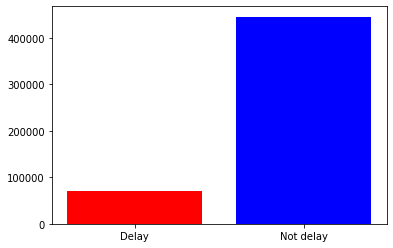

In [9]:

plt.bar(["Delay", "Not delay"],[Y.sum(), Airline.shape[0]], color= ["red", "blue"])

In [10]:
## since the dataset is very unbalanced I use resample 

class0 = X[Y==0]
class1 = X[Y==1]

print(len(class0), len(class1))

rnd.seed(39)
X0_ds = resample(class0, replace = False, n_samples = len(class1))
print(len(X0_ds),len(class1))
X_b = pd.concat([X0_ds, class1])
Y_b= Y[X_b.index]

362416 70882
70882 70882


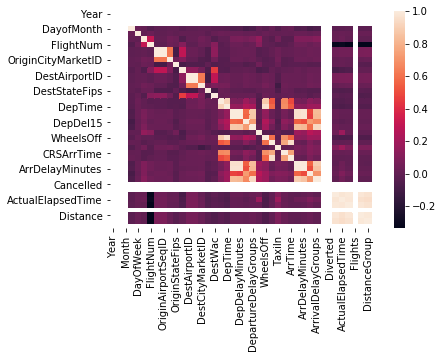

In [11]:
X_cor = X_b.corr()
sn.heatmap(X_cor)
plt.show()

In [12]:
## I calculate the Pearson correlation among the variables and I exclude those higher than 80 % 

to_drop = set()
for i in range(len(X_cor.columns)):
    for j in range(i):
        if abs(X_cor.iloc[i,j]) > 0.80:
            to_drop.add(X_cor.columns[i])
        
print(to_drop)

{'WheelsOff', 'ActualElapsedTime', 'DistanceGroup', 'DepartureDelayGroups', 'ArrTime', 'ArrDelayMinutes', 'ArrivalDelayGroups', 'Distance', 'DepDelayMinutes', 'DestAirportSeqID', 'OriginAirportSeqID', 'ArrDelay', 'AirTime', 'DepTime'}


In [13]:
X_b.drop(list(to_drop),axis=1, inplace=True)
X_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141764 entries, 222846 to 445823
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                141764 non-null  int64  
 1   Quarter             141764 non-null  int64  
 2   Month               141764 non-null  int64  
 3   DayofMonth          141764 non-null  int64  
 4   DayOfWeek           141764 non-null  int64  
 5   FlightDate          141764 non-null  object 
 6   UniqueCarrier       141764 non-null  object 
 7   AirlineID           141764 non-null  int64  
 8   Carrier             141764 non-null  object 
 9   TailNum             141764 non-null  object 
 10  FlightNum           141764 non-null  int64  
 11  OriginAirportID     141764 non-null  int64  
 12  OriginCityMarketID  141764 non-null  int64  
 13  Origin              141764 non-null  object 
 14  OriginCityName      141764 non-null  object 
 15  OriginState         141764 no

In [14]:
## I only keep the numeric columns

X_num = X_b.select_dtypes(include=['float64'])
X_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141764 entries, 222846 to 445823
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DepDelay        141764 non-null  float64
 1   DepDel15        141764 non-null  float64
 2   TaxiOut         141764 non-null  float64
 3   WheelsOn        141764 non-null  float64
 4   TaxiIn          141764 non-null  float64
 5   CRSElapsedTime  141764 non-null  float64
 6   Flights         141764 non-null  float64
dtypes: float64(7)
memory usage: 8.7 MB


In [15]:
X_num.describe()

,DepDelay,DepDel15,TaxiOut,WheelsOn,TaxiIn,CRSElapsedTime,Flights
count,141764.000000,141764.000000,141764.000000,141764.000000,141764.000000,141764.000000,141764.0
mean,26.525550,0.402056,18.728690,1515.781136,7.871596,147.240131,1.0
std,59.034834,0.490315,12.372592,544.660485,7.114407,77.441617,0.0
min,-46.000000,0.000000,1.000000,1.000000,1.000000,21.000000,1.0
25%,-3.000000,0.000000,11.000000,1133.000000,4.000000,90.000000,1.0
50%,4.000000,0.000000,15.000000,1579.500000,6.000000,129.000000,1.0
75%,36.000000,1.000000,22.000000,1947.000000,9.000000,181.000000,1.0
max,1663.000000,1.000000,158.000000,2400.000000,155.000000,705.000000,1.0


In [16]:
X_num = X_num.drop(["Flights","DepDel15"],axis=1)
X_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141764 entries, 222846 to 445823
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DepDelay        141764 non-null  float64
 1   TaxiOut         141764 non-null  float64
 2   WheelsOn        141764 non-null  float64
 3   TaxiIn          141764 non-null  float64
 4   CRSElapsedTime  141764 non-null  float64
dtypes: float64(5)
memory usage: 6.5 MB


In [17]:
## scaling of the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X_num)

In [22]:
## I use the random froest classifier with various random split and number of base decision tree
stimatori = range(2,100,5)
scoreRF= []
for i in range(5):
    train_X,test_X,train_Y, test_Y = train_test_split(X_std, Y_b,train_size=0.7, test_size=0.3,random_state=i)
    scores=[]
    for j in stimatori:
        clf_RF = RandomForestClassifier(n_estimators=j)
        clf_RF.fit(train_X,train_Y)
        pred_Y=clf_RF.predict(test_X)
        #scoreRF.append(round(clf_RF.score(test_X,test_Y)*100,2))
        scores.append(round((1 -(test_Y!=pred_Y).mean())*100,2))
    scoreRF.append(scores)
print(scoreRF)

[[88.36, 90.85, 91.41, 91.5, 91.74, 91.72, 91.8, 91.86, 91.72, 91.73, 91.83, 91.82, 91.8, 91.87, 91.88, 91.9, 91.93, 91.84, 91.87, 91.97], [88.38, 90.93, 91.23, 91.49, 91.47, 91.49, 91.55, 91.63, 91.59, 91.76, 91.73, 91.67, 91.73, 91.72, 91.82, 91.75, 91.76, 91.72, 91.76, 91.76], [88.35, 90.95, 91.34, 91.48, 91.55, 91.65, 91.71, 91.77, 91.7, 91.73, 91.8, 91.83, 91.77, 91.84, 91.79, 91.78, 91.73, 91.74, 91.84, 91.8], [88.45, 91.0, 91.21, 91.41, 91.51, 91.57, 91.62, 91.53, 91.58, 91.54, 91.67, 91.72, 91.68, 91.65, 91.72, 91.7, 91.66, 91.72, 91.66, 91.63], [88.24, 90.65, 90.92, 91.21, 91.32, 91.34, 91.34, 91.5, 91.43, 91.48, 91.48, 91.43, 91.44, 91.52, 91.55, 91.54, 91.6, 91.51, 91.59, 91.54]]


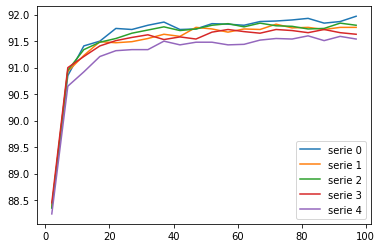

In [23]:
for i in range(5):
    plt.plot(stimatori, scoreRF[i], label = "serie " + str(i))
plt.legend()

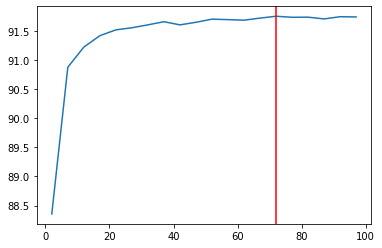

In [39]:
score_array = np.array(scoreRF)
plt.plot(stimatori,score_array.mean(axis=0))
plt.axvline(x=stimatori[score_array.mean(axis=0).argmax()],color='red')

In [36]:
print(score_array.mean(axis=0))
score_array.mean(axis=0).argmax()

[88.356 90.876 91.222 91.418 91.518 91.554 91.604 91.658 91.604 91.648
 91.702 91.694 91.684 91.72  91.752 91.734 91.736 91.706 91.744 91.74 ]


88.35600000000001

In [38]:
stimatori[score_array.mean(axis=0).argmax()]

72

In [47]:
best = stimatori[score_array.mean(axis=0).argmax()]
worst = stimatori[score_array.mean(axis=0).argmin()]

score_b = []
score_w = []

rnd.seed(89)

for i in range(12):
    train_X,test_X,train_Y, test_Y = train_test_split(X_std, Y_b,train_size=0.7, test_size=0.3,random_state=i )
    Rfc_b = RandomForestClassifier(n_estimators=best)
    Rfc_w = RandomForestClassifier(n_estimators= worst)
    Rfc_b.fit(train_X,train_Y)
    Rfc_w.fit(train_X,train_Y)
    score_b.append(round(Rfc_b.score(test_X,test_Y)*100,2))
    score_w.append(round(Rfc_w.score(test_X,test_Y)*100,2))

print(score_b,score_w)

[91.79, 91.8, 91.78, 91.7, 91.57, 91.65, 91.78, 91.75, 91.75, 91.88, 91.61, 91.81] [88.33, 88.46, 88.3, 88.28, 88.3, 88.23, 88.22, 88.01, 88.48, 88.68, 88.17, 88.32]


In [50]:
from scipy.stats import wilcoxon
wilcoxon(score_b,score_w)
## according to the WilCoxon test, there is a significative difference in the median of the two series

WilcoxonResult(statistic=0.0, pvalue=0.002200340526906492)